# Sensitivity Analysis for ABS

Author: A.Pilko <a.pilko@soton.ac.uk>

In [1]:
import numpy as np
import pandas as pd
import os
import sys
from pyDOE2 import *
import subprocess
import joblib as jl

### Parameters


In [10]:
## Constants
BOUNDS = '-145176.17270300398,-101964.24515822314,6569893.199178016,6595219.236650961,0,1524'
PROJ_PATH = '/home/aliaksei/PycharmProjects/sandbox/abs_tester/'
OWNPATH_PATH = PROJ_PATH + 'test_data/path.csv'
OWNPATH_PATH_LENGTH = 68818.61266545641
ALTS_PATH = PROJ_PATH + 'test_data/alts.csv'
TRACKS_PATH = PROJ_PATH + 'test_data/tracks.csv'
VELS_PATH = PROJ_PATH + 'test_data/vels.csv'
VERTS_PATH = PROJ_PATH + 'test_data/vert_rates.csv'

BINARY_NAME = '/home/aliaksei/GoProjects/abs-specific/abs-specific'
cmd_args = [BINARY_NAME, '--bounds', BOUNDS, '--simOps', '6000000', '--altDataPath', ALTS_PATH,'--velDataPath', VELS_PATH, '--trackDataPath', TRACKS_PATH, '--vertRateDataPath', VERTS_PATH, '--ownPath', OWNPATH_PATH]

RESULT_DIR = PROJ_PATH + 'results'

### Design of Experiments

In [3]:
traffic_density_levels = [1e-11, 1e-13]
timestep_levels = [1, 2]
# surface_entrance_levels = [0,1]
own_velocity_levels = [40, 60, 80]

design_matrix = fullfact([len(traffic_density_levels), len(timestep_levels), len(own_velocity_levels)])
# design_matrix = bbdesign(3)
def fill_dm(row):
    return traffic_density_levels[int(row[0])], timestep_levels[int(row[1])],  own_velocity_levels[int(row[2])]
design_matrix = np.apply_along_axis(fill_dm, 1, design_matrix)
design_matrix

array([[1.e-11, 1.e+00, 4.e+01],
       [1.e-13, 1.e+00, 4.e+01],
       [1.e-11, 2.e+00, 4.e+01],
       [1.e-13, 2.e+00, 4.e+01],
       [1.e-11, 1.e+00, 6.e+01],
       [1.e-13, 1.e+00, 6.e+01],
       [1.e-11, 2.e+00, 6.e+01],
       [1.e-13, 2.e+00, 6.e+01],
       [1.e-11, 1.e+00, 8.e+01],
       [1.e-13, 1.e+00, 8.e+01],
       [1.e-11, 2.e+00, 8.e+01],
       [1.e-13, 2.e+00, 8.e+01]])

In [8]:
def run(traffic_density, timestep, own_velocity):
    output_db_name = f'{RESULT_DIR}/out_{traffic_density:.1e}_{timestep:.1e}_True_{own_velocity:.1e}.db'
    # print(' '.join(cmd_args + ['--db-path', output_db_name,'--target-density', str(traffic_density), '--timestep', str(timestep)]))
    os.system(' '.join(cmd_args + ['--dbPath', output_db_name,'--target-density', str(traffic_density), '--timestep', str(timestep), '--surfaceEntrance', str(True).lower(), '--ownVelocity', str(own_velocity)]))

# for row in design_matrix:
#     run(*row)

In [19]:
# Hour of day is 1100, freq density is 0.075
single_run_args = [2.53e-11 * 0.075, 0.1, 60]
run(*single_run_args)
# jl.Parallel(n_jobs=-1, verbose=10)(jl.delayed(run)(*single_run_args) for _ in range(os.cpu_count()))

Created/Opened output database
Running 16 batches of 187500 simulations
Simulating 9.558140647980057e+06 total hrs, 3.186046882660019 hrs per simulation, 597383.7904987535 hrs per batch
Simulating 5.505489013236512e+11 total timesteps, 1146.9768777576069 timesteps per simulation, 3.44093063327282e+10 timesteps per batch
Completed 0 sims in batch 0 
Completed 0 sims in batch 7 
Completed 0 sims in batch 6 
Completed 0 sims in batch 5 
Completed 0 sims in batch 8 
Completed 0 sims in batch 4 
Completed 0 sims in batch 2 
Completed 0 sims in batch 11 
Completed 0 sims in batch 12 
Completed 0 sims in batch 14 
Completed 0 sims in batch 1 
Completed 0 sims in batch 9 
Completed 0 sims in batch 3 
Completed 0 sims in batch 15 
Completed 0 sims in batch 13 
Completed 0 sims in batch 10 
Completed 9375 sims in batch 2 
Completed 9375 sims in batch 12 
Completed 9375 sims in batch 5 
Completed 9375 sims in batch 11 
Completed 9375 sims in batch 13 
Completed 9375 sims in batch 8 
Completed 937

In [ ]:
jl.Parallel(n_jobs=-1, verbose=10)(jl.delayed(run)(*row) for row in design_matrix)

In [38]:
import sqlite3
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

results = []

for db in glob(RESULT_DIR+'/**'):
    filename = Path(db).stem
    tokens = filename.split('_')
    traffic_density = float(tokens[1])
    timestep = float(tokens[2])
    surface_entrance = tokens[3] == 'True'
    own_velocity = float(tokens[4])

    dbcon = sqlite3.connect(db)
    dbcur = dbcon.cursor()
    res = dbcur.execute("SELECT * FROM sims").fetchall()
    sim_data = np.array(res, dtype=np.longlong)[:, 2:]
    sim_data = np.cumsum(sim_data, axis=0)
    n_sims = sim_data.shape[0]
    n_conflicts = sim_data[-1,1]
    sim_data = np.hstack((sim_data, (sim_data[:, 1] / (sim_data[:, 0]/3600))[:, None]))

    # fig, ax = plt.subplots(
    #     1, 1, figsize=(12,6),
    # )
    #
    # ax.plot(range(sim_data.shape[0]), sim_data[:, 2])
    # ax.axhline(np.median(sim_data[:,2]), color='red', linestyle=':')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.set_title(f"ABS convergence\nTraffic Density {traffic_density:1e} m$^{-3}$ hr$^{-1}$ \nTimestep {timestep:.1e}s\nSurface Entrance {surface_entrance}")
    # ax.set_xlabel("Operations Simulated")
    # ax.set_ylabel("uMAC Risk/hour")
    # print(f'Traffic Density {traffic_density:1e} m$^{-3}$ hr$^{-1}$ \nTimestep {timestep:.1e}s\nSurface Entrance {surface_entrance} \nMedian uMAC rate {np.median(sim_data[:,2]):2e} per hour\n\n-----------------\n\n')

    conflict_sum = sim_data[:, 2].sum()
    sim_secs = (OWNPATH_PATH_LENGTH/70)*sim_data.shape[0]
    sim_hrs = sim_secs / (60*60)
    # sim_hrs = sim_data[:, 1].sum() / (60*60)
    sim_ops = sim_data.shape[0]
    mean_col_rate = conflict_sum / sim_hrs
    median_col_rate = np.median(sim_data[:,2])
    conv_metric = 1- (np.abs(np.diff(sim_data[-5000:,2]).sum())/median_col_rate)
    results.append([traffic_density, timestep, surface_entrance, own_velocity, sim_hrs, median_col_rate, conv_metric])

/tmp/ipykernel_226639/2177396780.py:46: RuntimeWarning: invalid value encountered in double_scalars
  conv_metric = 1- (np.abs(np.diff(sim_data[-5000:,2]).sum())/median_col_rate)
/tmp/ipykernel_226639/2177396780.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  conv_metric = 1- (np.abs(np.diff(sim_data[-5000:,2]).sum())/median_col_rate)


In [39]:
res_df = pd.DataFrame(results, columns=['traffic_density', 'timestep', 'surface_entrance', 'own_velocity', 'sim_hours', 'uMAC_per_hour', 'convergence']).dropna(axis=0)
# res_df = res_df[res_df['timestep'] <= 2]

In [56]:
corr = res_df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,traffic_density,timestep,surface_entrance,own_velocity,sim_hours,uMAC_per_hour,convergence
traffic_density,1.000000,0.001761,-0.063355,-0.049233,-0.183305,0.830189,-0.011832
timestep,0.001761,1.000000,0.021047,-0.039900,0.149636,-0.445347,0.181385
surface_entrance,-0.063355,0.021047,1.000000,-0.140814,-0.244703,-0.084980,-0.145620
own_velocity,-0.049233,-0.039900,-0.140814,1.000000,0.070555,0.020716,-0.059884
sim_hours,-0.183305,0.149636,-0.244703,0.070555,1.000000,-0.193195,0.835848
uMAC_per_hour,0.830189,-0.445347,-0.084980,0.020716,-0.193195,1.000000,-0.072685
convergence,-0.011832,0.181385,-0.145620,-0.059884,0.835848,-0.072685,1.000000


In [42]:
density_groups = res_df.groupby('traffic_density')
density_group_means = density_groups['uMAC_per_hour'].mean()
density_group_stds = density_groups['uMAC_per_hour'].std()
density_group_means.index.values

array([1.e-15, 1.e-13, 1.e-12, 1.e-11, 5.e-11, 1.e-10, 1.e-09])

Text(0, 0.5, 'uMAC Risk/hour')

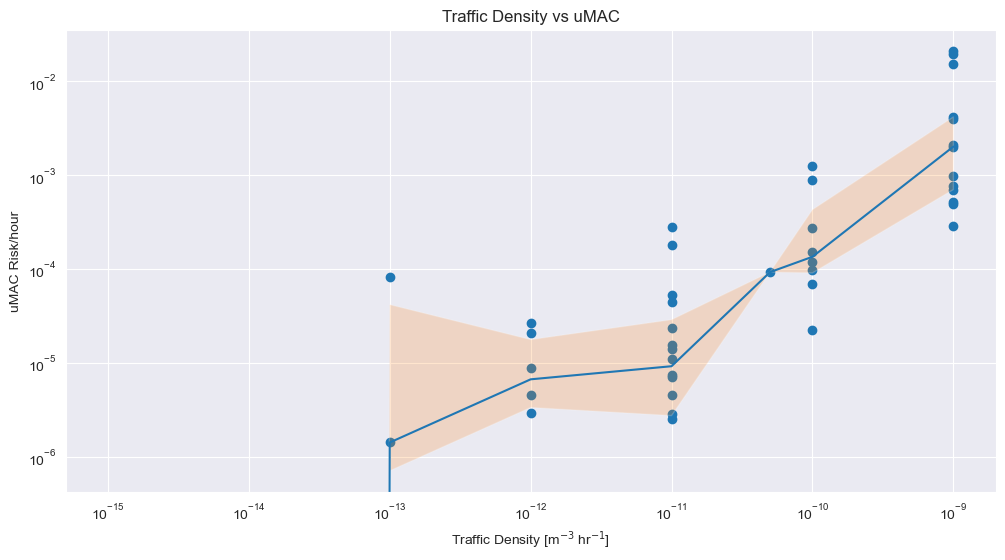

In [43]:

fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df['traffic_density'], res_df['uMAC_per_hour'])
density_group_means = density_groups['uMAC_per_hour'].mean()
ax.plot(density_groups['uMAC_per_hour'].median())
ax.fill_between(density_group_means.index.values, density_groups['uMAC_per_hour'].quantile(0.25), density_groups['uMAC_per_hour'].quantile(0.75), alpha=.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Traffic Density vs uMAC')
ax.set_xlabel("Traffic Density [m$^{-3}$ hr$^{-1}$]")
ax.set_ylabel("uMAC Risk/hour")

Text(0, 0.5, 'uMAC Risk/hour')

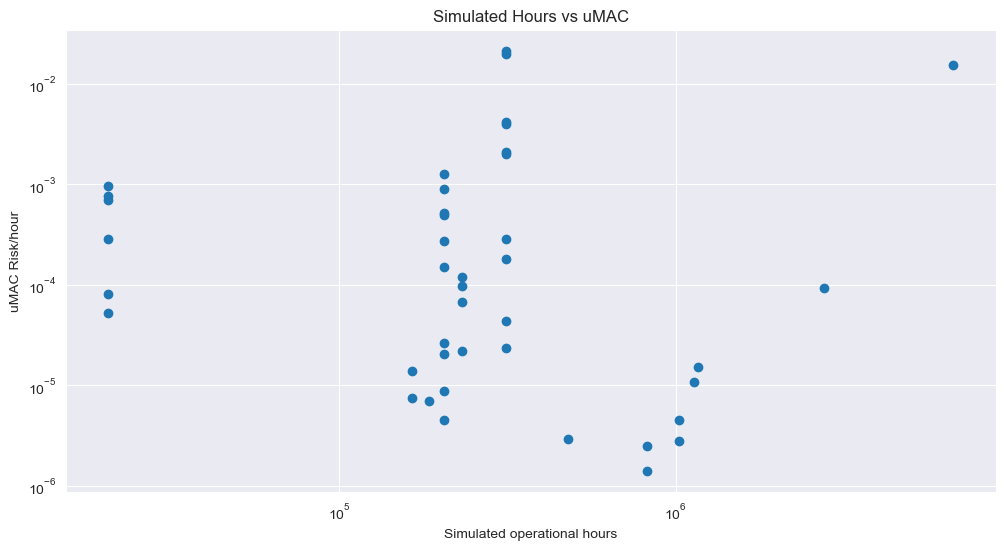

In [44]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df['sim_hours'], res_df['uMAC_per_hour'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Simulated Hours vs uMAC')
ax.set_xlabel("Simulated operational hours")
ax.set_ylabel("uMAC Risk/hour")

Text(0, 0.5, 'uMAC Risk/hour')

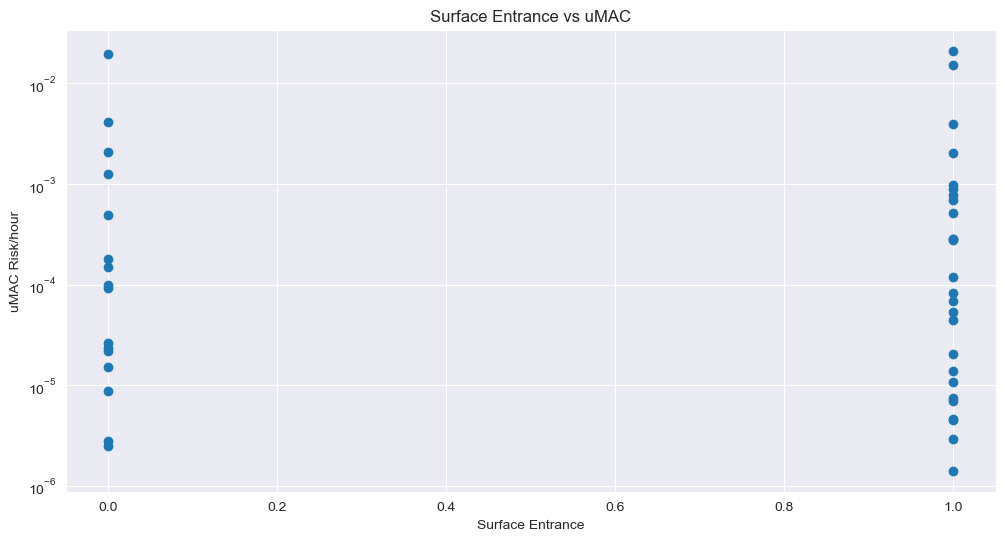

In [45]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df['surface_entrance'], res_df['uMAC_per_hour'])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Surface Entrance vs uMAC')
ax.set_xlabel("Surface Entrance")
ax.set_ylabel("uMAC Risk/hour")

Text(0, 0.5, 'uMAC Risk/hour')

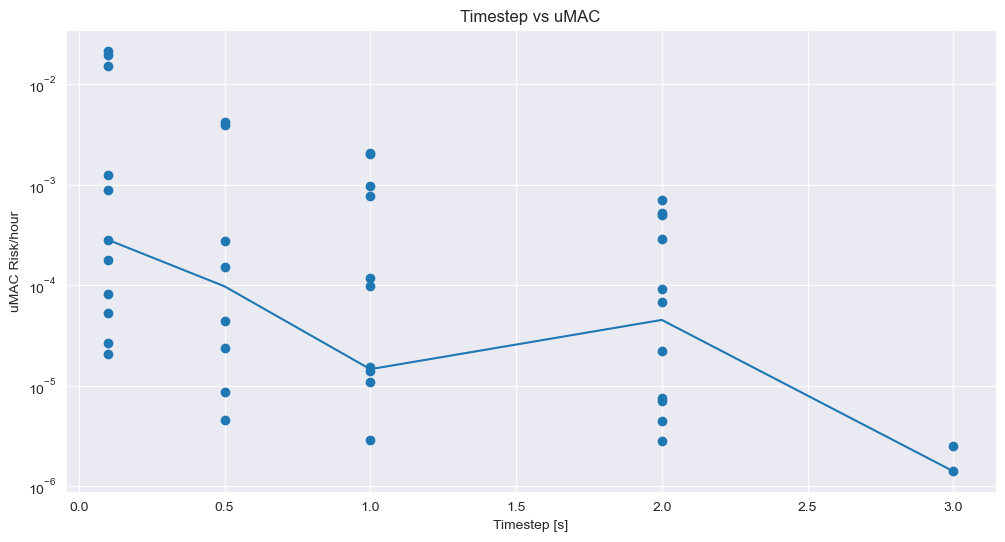

In [46]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df['timestep'], res_df['uMAC_per_hour'])

ts_groups = res_df.groupby('timestep')
ts_group_means = density_groups['uMAC_per_hour'].mean()
ax.plot(ts_groups['uMAC_per_hour'].median())
# ax.fill_between(ts_group_means.index.values, ts_groups['uMAC_per_hour'].quantile(0.25), ts_groups['uMAC_per_hour'].quantile(0.75), alpha=.2)

# ax.set_xscale('symlog')
ax.set_yscale('log')
ax.set_title('Timestep vs uMAC')
ax.set_xlabel("Timestep [s]")
ax.set_ylabel("uMAC Risk/hour")

In [47]:
ts_groups['uMAC_per_hour'].quantile(0.25)

timestep
0.1    6.740354e-05
0.5    1.991543e-05
1.0    7.310728e-07
2.0    6.393675e-06
3.0    7.058712e-07
Name: uMAC_per_hour, dtype: float64

Text(0, 0.5, 'uMAC Risk/hour')

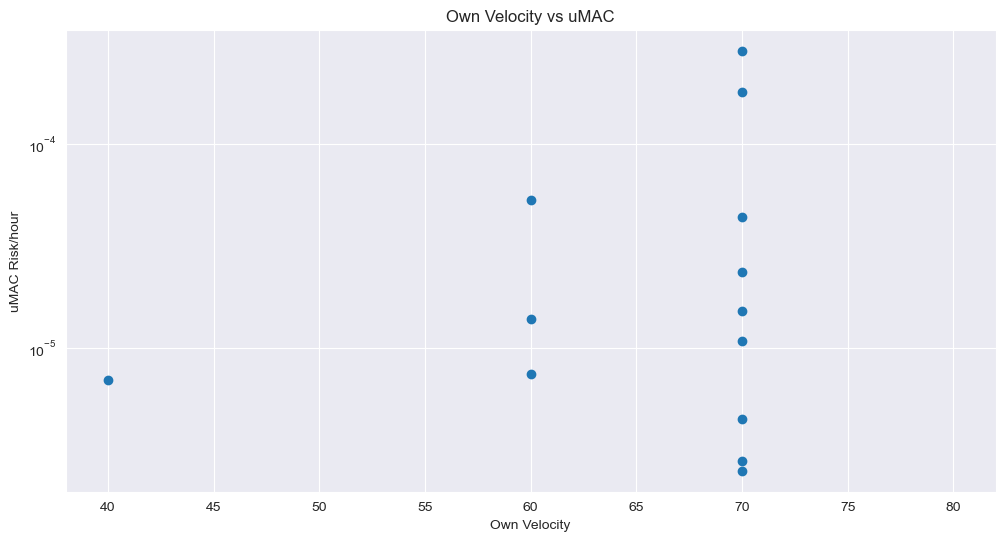

In [55]:
fig, ax = plt.subplots(
    1, 1, figsize=(12,6),
)

ax.scatter(res_df[res_df['traffic_density']==1e-11]['own_velocity'], res_df[res_df['traffic_density']==1e-11]['uMAC_per_hour'])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Own Velocity vs uMAC')
ax.set_xlabel("Own Velocity")
ax.set_ylabel("uMAC Risk/hour")

1.0    14
2.0    12
0.1    11
0.5     8
3.0     3
Name: timestep, dtype: int64